## Problem Statement

Build an end-to-end regression project to predict individual medical insurance costs based on factors such as age, gender, BMI, smoking status, and number of dependents. Utilize the provided dataset to clean and engineer features, train multiple regression models, and deploy the best model in a Streamlit application. The app should allow users to input personal health and demographic details to estimate their medical insurance costs.


## Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the data

insurance = pd.read_csv("C:/Users/Nil/Documents/GUVI PROJECT/Medical Insurance Predict ML/data/medical_insurance.csv")

In [3]:
# Show the top five rows

insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Some Basic Analysis

In [4]:
# Information about the dataset

insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [5]:
# Statistical information of the numeric columns

insurance.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# Unique values for categorical columns

column = ['sex','smoker','region']

for col in column:
    print(insurance[col].value_counts(),"\n")

sex
male      1406
female    1366
Name: count, dtype: int64 

smoker
no     2208
yes     564
Name: count, dtype: int64 

region
southeast    766
southwest    684
northwest    664
northeast    658
Name: count, dtype: int64 



In [7]:
# Check for Null Values

insurance.isnull().sum().any()

False

In [8]:
# Check for Duplicate Rows

insurance.duplicated().sum()

1435

Here 1435 rows are duplicate, so we remove these rows to maintain clean data

In [9]:
# Drop the duplicated rows

insurance = insurance.drop_duplicates()

<Axes: ylabel='charges'>

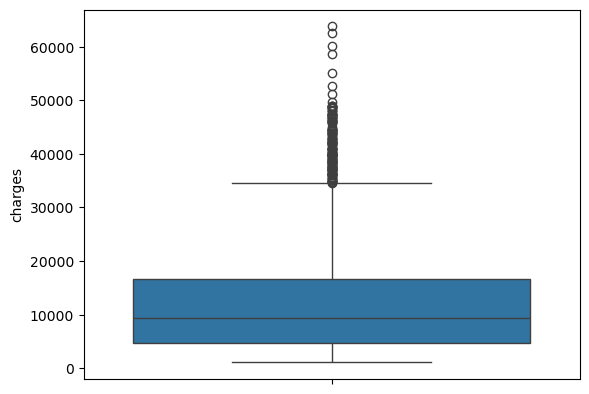

In [10]:
# Plot the boxplot to see outliers

sns.boxplot(insurance['charges'])

After 50000, there are some outliers. So we remove them for best prediction.

## Data Cleaning & Preprocessing

In [11]:
# Removing some negligible outliers

insurance= insurance[insurance['charges']<50000]

In [12]:
# Encode the sex, smoker, region column

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

insurance['sex'] = encoder.fit_transform(insurance['sex'])
insurance['smoker'] = encoder.fit_transform(insurance['smoker'])
insurance['region'] = encoder.fit_transform(insurance['region'])

<Axes: >

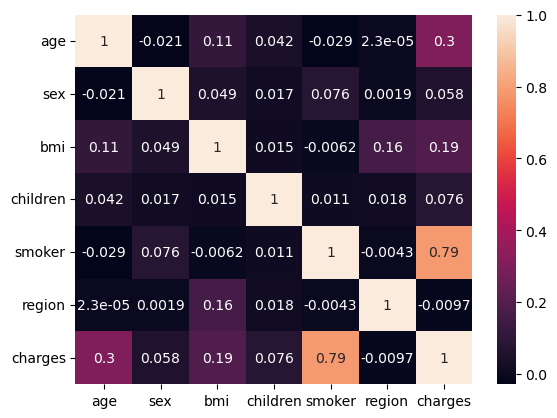

In [13]:
# Plot a heatmap to see the correlation between features 

sns.heatmap(insurance.corr(), annot = True)

Here the input features "sex,children,region" has no significant correlation with output variable 'charges'.
So, we do not use them for model training.

In [14]:
# Feature Engineering

insurance['smoker*bmi'] = insurance['smoker'] * insurance['bmi']

In [15]:
insurance[['charges','smoker*bmi']].corr()

,charges,smoker*bmi
charges,1.000000,0.842226
smoker*bmi,0.842226,1.000000


This new feature has strong correlation with the target variable.

In [16]:
# Assign X and y and divide it into training and testing data

X = insurance[['age','smoker*bmi']]
y = insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## Model with mlflow

In [17]:
# Set tracking URI & Experiment

mlflow.set_tracking_uri("file:///C:/Users/Nil/Documents/GUVI PROJECT/Medical Insurance Predict ML/mlruns")
mlflow.set_experiment("Medical_Insurance_Experiments")

def ml_model(name,model):
    
    with mlflow.start_run(run_name = name):
    
        # Model Fitting
        model.fit(X_train, y_train)
    
        # Model Prediction
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
    
        # Errors in models
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        r2_train = r2_score(y_train, y_train_pred)

        print(name)
        print("mae : ", mae, "| mae_train:",mae_train)
        print("rmse :", rmse, "| rmse_train:",rmse_train)
        print("r2 :", r2, " | r2_train:",r2_train)

        # Log all metric into mlflow
        mlflow.log_param("model_name", name)
        
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)
        
        if isinstance(model, xgb.XGBRegressor):
            mlflow.xgboost.log_model(model, name="model")
        else:
            mlflow.sklearn.log_model(model, name="model")

## Model Run

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

models = {'LinearRegression' : LinearRegression(),
          'DecisionTreeRegressor' : DecisionTreeRegressor(max_depth=5),
          'RandomForestRegressor' : RandomForestRegressor(n_estimators=150, max_depth=5),
          'GradientBoostingRegressor' : GradientBoostingRegressor(n_estimators= 50, max_depth = 3),
          'xgb.XGBRegressor' : xgb.XGBRegressor(n_estimators=40, max_depth=2)
         }


In [19]:
for name,model in models.items():
    ml_model(name,model)

LinearRegression
mae :  3236.145224371045 | mae_train: 3105.658640709253
rmse : 5170.233250367299 | rmse_train: 5016.783554019065
r2 : 0.8100120609537214  | r2_train: 0.8145455889629025


2025/07/25 00:47:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTreeRegressor
mae :  2373.73285247555 | mae_train: 2333.6583890148963
rmse : 4367.854028769243 | rmse_train: 4229.388254783074
r2 : 0.8644055258851622  | r2_train: 0.868192067112886


2025/07/25 00:47:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestRegressor
mae :  2279.7600979556146 | mae_train: 2307.7430298767626
rmse : 4275.26195510648 | rmse_train: 4206.313574836506
r2 : 0.8700933991418818  | r2_train: 0.8696263781684719


2025/07/25 00:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoostingRegressor
mae :  2272.6780172874915 | mae_train: 2285.260109683445
rmse : 4238.627524860335 | rmse_train: 4195.6293778981835
r2 : 0.8723101822771981  | r2_train: 0.8702878449703773


2025/07/25 00:48:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgb.XGBRegressor
mae :  2314.9164188522086 | mae_train: 2327.653689423476
rmse : 4318.311243453688 | rmse_train: 4238.07085904826
r2 : 0.8674640666029682  | r2_train: 0.8676503287950432


2025/07/25 00:48:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Here for low rmse and high r2 score, we choose GradientBoostingRegressor Model as best model.